# Figure S9

Ablation of cell-specific diffusion detracts from scDiffEq’s ability to accurately predict cell fate

## Setup

Import packages, types, and set constants

In [1]:
import cellplots
import larry
import scdiffeq as sdq
import scdiffeq_analyses as sdq_an

from typing import Dict, List, Union

F_obs = larry.tasks.fate_prediction.F_obs
larry_cmap = larry.pl.InVitroColorMap()._dict

print(", ".join([f"{pkg.__name__}[{pkg.__version__}]" for pkg in [sdq, sdq_an, larry, cellplots]]))

scdiffeq[0.1.6], scdiffeq_analyses[0.0.1], larry[0.1.0dev0], cellplots[0.0.1rc0]


In [2]:
project_path_ctrl = "/Users/michaelvinyard/GitHub/scdiffeq-analyses/manuscript/models/LARRY.fate_prediction/LightningSDE-FixedPotential-RegularizedVelocityRatio/"
project_path_ablt = "/Users/michaelvinyard/LightningODE-FixedPotential/"

project_ctrl = sdq.io.Project(path=project_path_ctrl)
project_ablt = sdq.io.Project(path=project_path_ablt)

## Define helper functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def get_optimized_conditions(
    project,
    mu_hidden: List[int] = [512,512],
    sigma_hidden: List[int] = [32,32],
    velocity_ratio_params: Dict[str,Union[float,str]] = {'enforce': 100.0, 'method': 'square', 'target': 2.5},    
):
    
    versions = sdq_an.parsers.list_project_versions(project)
    
    optimized = []
    
    for version in versions:
        mu = version.hparams.mu_hidden == [512,512]
        sigma = version.hparams.sigma_hidden == [32,32]
        vr = version.hparams.velocity_ratio_params == {'enforce': 100.0, 'method': 'square', 'target': 2.5}
        if all([mu, sigma, vr]):
            optimized.append(version)

    return sdq_an.parsers.best_checkpoints(project).loc[[item._NAME for item in optimized]]

def convert_name(path):
    return path.name.split(".ckpt")[0].replace("=", "_").replace("-", ".")

def aggr_ce(F_obs: pd.DataFrame, best_ckpts: pd.DataFrame):
    """

    Args:
        best_ckpts (pd.DataFrame): the dataframe produced by sdq_an.parsers.best_checkpoints(project=project)
    """
    ce_list = []
    for version, version_path in best_ckpts['ckpt_path'].items():
        ckpt = sdq.io.Checkpoint(version_path)
        ce_list.append(sdq_an.metrics.cross_entropy(F_obs=F_obs, F_hat=ckpt.F_hat))

    ce_arr = np.array(ce_list)

    print(f"Cross Entropy: {ce_arr.mean():.2f}±{ce_arr.std():.2f}")
    
    return ce_arr

## Get the best checkpoints for the optimized model

In [54]:
best_ckpts_ctrl = get_optimized_conditions(project_ctrl)
best_ckpts_ctrl['test']
best_ckpts_ctrl['test'].mean(), best_ckpts_ctrl['test'].std()

(0.5469150174621653, 0.029201233238860373)

## Get the best checkpoints for the ablated models

In [53]:
best_ckpts_ablt = sdq_an.parsers.best_checkpoints(project=project_ablt)
best_ckpts_ablt['test'].mean(), best_ckpts_ablt['test'].std()

(0.43562281722933643, 0.025523715624451156)

## Plot compared model accuracy

### Plot dominant fate accuracy scores (Suppl. Fig. 9a)

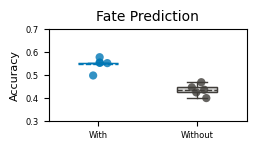

In [48]:
cmap = {"with": "#0077b6", "without": "#403d39"}

data = {
    "with": best_ckpts_ctrl['test'].tolist(),
    "without": best_ckpts_ablt['test'].tolist()
}

fig, axes = cellplots.plot(height = 0.25, width = 0.4, title = ['Fate Prediction'], y_label=['Accuracy'])
bp = sdq_an.pl.boxplot(data, ax = axes[0], widths=0.4, colors=list(cmap.values()))
axes[0].set_ylim(0.3, 0.7)
axes[0].set_xticks([1, 2])
xtl = axes[0].set_xticklabels(['With', 'Without'])
plt.savefig("fate_prediction.ablate_diffusion.accuracy_score.FigureS9a.svg")

### Aggregate Cross Entropy for both models

In [49]:
ce_ctrl = aggr_ce(F_obs, best_ckpts_ctrl)
ce_ablt = aggr_ce(F_obs, best_ckpts_ablt)

Cross Entropy: 4.90±0.25
Cross Entropy: 16.58±0.58


### Plot compared Cross Entropy (Suppl. Fig. 9b)

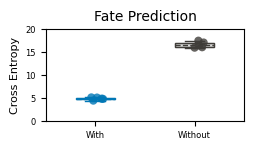

In [50]:
data = {
    "with": ce_ctrl,
    "without": ce_ablt,
}

fig, axes = cellplots.plot(height = 0.25, width = 0.4, title = ['Fate Prediction'], y_label=['Cross Entropy'])
bp = sdq_an.pl.boxplot(data, ax = axes[0], widths=0.4, colors=list(cmap.values()))
axes[0].set_ylim(0, 20)
axes[0].set_xticks([1, 2])
xtl = axes[0].set_xticklabels(['With', 'Without'])
plt.savefig("fate_prediction.ablate_diffusion.cross_entropy.FigureS9b.svg")

## Observe impact on predictions

### Plot the number of predicted fates for each model (Suppl. Fig. 9c)

In [10]:
def annnotate(ax, y_arr, colors=None):
    for en, (x, y) in enumerate(y_arr.to_dict().items()):
        if colors is None:
            c = "k"
        else:
            c = colors[en]
        ax.text(x=x, y=y + 50, s=y, ha="center", fontsize = 6, color = c)

def augment_missing_cols(F_obs, F_hat):
    """Augment the missing columns in F_hat"""
    F_hat = F_hat.copy()
    for col in F_obs.columns:
        if not col in F_hat:
            F_hat[col] = 0
    return F_hat

def process_predictions(F_obs, F_hat):
    F_hat = F_hat.copy()
    F_hat = augment_missing_cols(F_obs, F_hat)
    F_hat = F_hat.drop("Undifferentiated", axis = 1)
    return F_hat.div(F_hat.sum(1), axis = 0).fillna(0)

def get_median_model_ckpt_path(best_ckpts: pd.DataFrame, key: str = "test"):
    """From the best ckpts of each model version, choose the median performing version"""
    ckpt_paths = best_ckpts[best_ckpts['test'] == best_ckpts['test'].median()]['ckpt_path'].values
    assert len(ckpt_paths) == 1, "too many ckpt paths, something is wrong"
    return ckpt_paths[0]

In [11]:
ckpt_path_ablt = get_median_model_ckpt_path(best_ckpts_ablt)
ckpt_path_ctrl = get_median_model_ckpt_path(best_ckpts_ctrl)

F_hat_ctrl = process_predictions(F_obs, sdq.io.Checkpoint(ckpt_path_ctrl).F_hat)
F_hat_ablt = process_predictions(F_obs, sdq.io.Checkpoint(ckpt_path_ablt).F_hat)

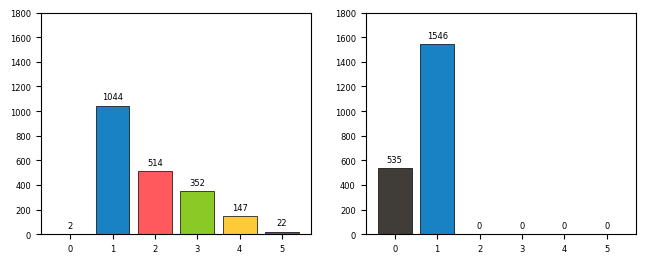

In [12]:
colors = ["#403d39", "#1982c4", "#ff595e", "#8ac926", "#ffca3a", "#6a4c93"]

y0 = (F_hat_ctrl > 0.05).sum(1).value_counts().sort_index()
y1 = (F_hat_ablt > 0.05).sum(1).value_counts().sort_index()
y1 = y1.to_dict()
y1.update({2: 0, 3: 0, 4: 0, 5: 0})
y1 = pd.Series(y1)

fig, axes = cellplots.plot(nplots=2, ncols=2, wspace = 0.2, height = 0.6, width = 0.6)
axes[0].bar(x=y0.index, height = y0.values, fc=colors, ec = "k", lw=0.5)
axes[1].bar(x=y1.index, height = y1.values, fc=colors, ec = "k", lw=0.5)
for ax in axes:
    ax.set_ylim(0, 1800)

annnotate(ax=axes[0], y_arr=y0)
annnotate(ax=axes[1], y_arr=y1)
plt.savefig("ablated_diffusion.n_fates.FigureS9cd.svg")

## Visually compare model predictions via UMAP

### Setup helper functions

In [51]:
import ABCParse
import anndata
import torch

def get_sorted_best_predictions(F_hat: pd.DataFrame, N: int = 3):
    F_hat.index = F_hat.index.astype(int)
    F_hat = F_hat.div(F_hat.sum(1), axis=0)
    n_fate_F_obs = F_obs.loc[(F_obs > 0).sum(1) == N]
    n_fate_F_hat = F_hat.loc[n_fate_F_obs.index.astype(int)]
    filt_f_hat = n_fate_F_hat.loc[(n_fate_F_hat > 0).sum(1) == N]
    filt_f_obs = F_obs.loc[filt_f_hat.index.astype(str)]
    filt_nce = sdq_an.metrics.rowwise_negative_cross_entropy(filt_f_obs, filt_f_hat)
    sorted_best = filt_f_hat.iloc[np.argsort(filt_nce)]
    sorted_best.index = sorted_best.index.astype(str)
    return sorted_best

def plot_lineage(adata_lin: anndata.AnnData, ax: plt.Axes):

    coarse_cmap = {2: "#fec729", 4: "#cc4a77", 6: "#2f2d85"}

    axes = cellplots.umap(
        adata_lin,
        groupby="Time point",
        ax=ax,
        force_zorder={2: 301, 4: 302, 6: 303},
        c="w",
        s=80,
    )
    axes = cellplots.umap(
        adata_lin,
        groupby="Time point",
        ax=ax,
        force_zorder={2: 301, 4: 302, 6: 303},
        c="k",
        s=60,
    )
    axes = cellplots.umap(
        adata_lin,
        groupby="Time point",
        cmap=coarse_cmap,
        ax=ax,
        force_zorder={2: 311, 4: 312, 6: 313},
        s=40,
    )
    
def plot(adata, adata_sim_ctrl, adata_sim_ablt):
    axes = cellplots.umap_manifold(
        adata,
        nplots=2,
        ncols=2,
        c_background=larry_cmap,
        groupby="Cell type annotation",
    )
    cellplots.umap(adata_sim_ctrl, c=adata_sim_ctrl.obs['t'], ax=axes[0], cmap=sdq_an.pl.temporal_colormap)
    cellplots.umap(adata_sim_ablt, c=adata_sim_ablt.obs['t'], ax=axes[1], cmap=sdq_an.pl.temporal_colormap)
    return axes

def simulate(adata, model_ctrl, model_ablt, idx, N = 200, t = torch.linspace(2, 6, 41)):

    idx = ABCParse.as_list(idx)
    for en, ix in enumerate(idx):
        adata_sim_ctrl = sdq.tl.simulate(adata=adata, diffeq=model_ctrl.DiffEq, idx = [ix], N = N, t = t)
        adata_sim_ablt = sdq.tl.simulate(adata=adata, diffeq=model_ablt.DiffEq, idx = [ix], N = N, t = t)
        adata_sim_ctrl.obsm['X_umap'] = umap_model.transform(adata_sim_ctrl.X)
        adata_sim_ablt.obsm['X_umap'] = umap_model.transform(adata_sim_ablt.X)
        axes = plot(adata, adata_sim_ctrl, adata_sim_ablt)
        adata_lin = sdq_an.tl.subset_lineage_adata(adata=adata, cell_idx=ix)
        titles = [f'scDiffEq (cell_idx={ix})', f'scDiffEq [diffusion-ablated] (cell_idx={ix})']
        for en_, ax in enumerate(axes):
            plot_lineage(adata_lin, ax=ax)
            ax.set_title(titles[en_])
        plt.savefig(f"umap_comparative_sim.idx_{ix}.{en}.FigureS9.svg", dpi = 200)
        plt.show()

### Load data

In [16]:
adata = sdq.datasets.larry()

scDiffEq [INFO]: Loading data from /Users/michaelvinyard/scdiffeq_data/larry/larry.h5ad


### Initialize dimensionality reduction models

In [17]:
import sklearn.decomposition
import sklearn.preprocessing
import umap

PCA = sklearn.decomposition.PCA(n_components=50)
scaler = sklearn.preprocessing.StandardScaler()
umap_model = umap.UMAP()

### Fit dimensionality reduction models to only the fate prediciton training data

In [18]:
adata.obs['train'] = adata.obs['Well'].isin([0, 1])
adata_train = adata[adata.obs['train']].copy()
X_raw = adata_train.X.A
X_scaled = scaler.fit_transform(X_raw)
X_pca = PCA.fit_transform(X_scaled)
X_umap = umap_model.fit_transform(X_pca)
adata.obsm['X_umap'] = umap_model.fit_transform(adata.obsm['X_pca'])

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


### Get some good example bi-fated predictions

Initially, I wnated to pick the most accurate multi-potent progenitor predictions for each model to ensure a fair comparison. However, as I found above there were no overlapping multi-fated predictions because the ablated diffusion model can only predict a single fate.

In [19]:
best_bifated_predictions_ctrl = get_sorted_best_predictions(F_hat=F_hat_ctrl, N=2)
bifated_nm_preds = best_bifated_predictions_ctrl.loc[best_bifated_predictions_ctrl['Neutrophil'] > 0.1].loc[best_bifated_predictions_ctrl['Neutrophil'] < 0.9]

In [21]:
bifated_nm_preds

,Baso,Ccr7_DC,Eos,Erythroid,Lymphoid,Mast,Meg,Monocyte,Neutrophil,pDC
18550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.164179,0.835821,0.0
13525,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461030,0.538970,0.0
68506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.102264,0.897736,0.0


In [20]:
idx = bifated_nm_preds.index.tolist()

### Load scDiffEq models corresponding to the studied checkpoints

In [22]:
model_ctrl = sdq.io.load_model(adata=adata, ckpt_path=ckpt_path_ctrl)
model_ablt = sdq.io.load_model(adata=adata, ckpt_path=ckpt_path_ablt)

scDiffEq [INFO]: Input data configured.
scDiffEq [INFO]: Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


scDiffEq [INFO]: Input data configured.
scDiffEq [INFO]: Bulding Annoy kNN Graph on adata.obsm['train']


Seed set to 0


### Plot UMAPS (Suppl. Fig. 9e-g)

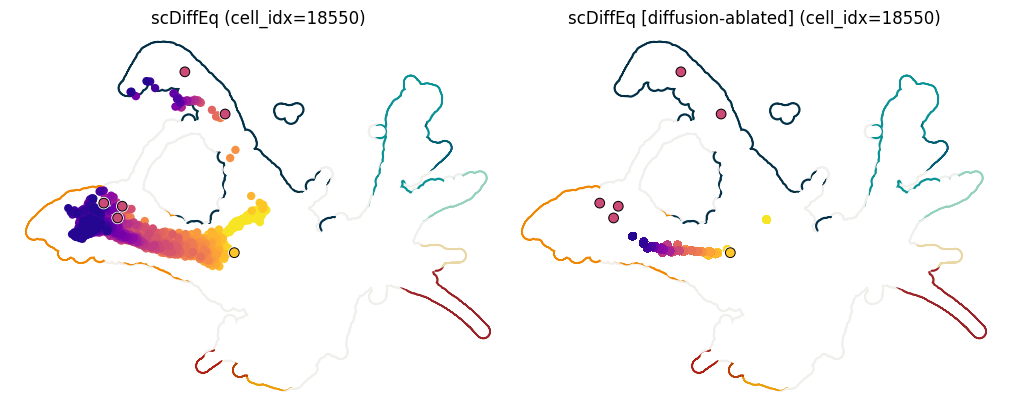

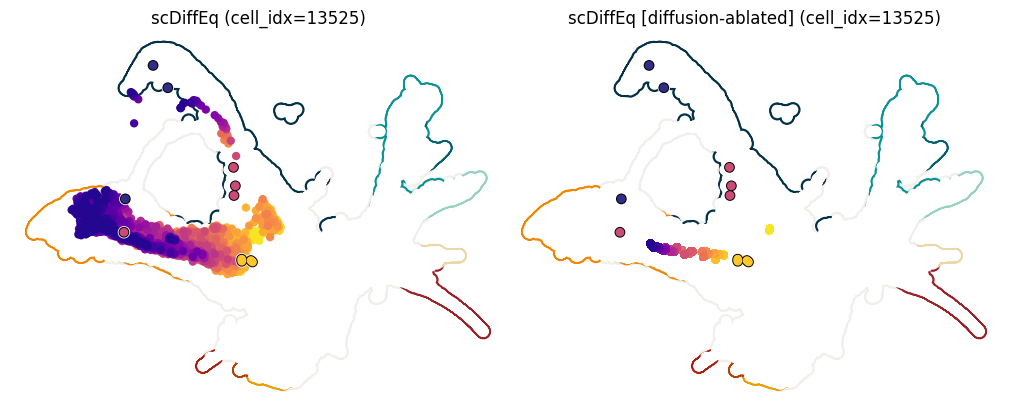

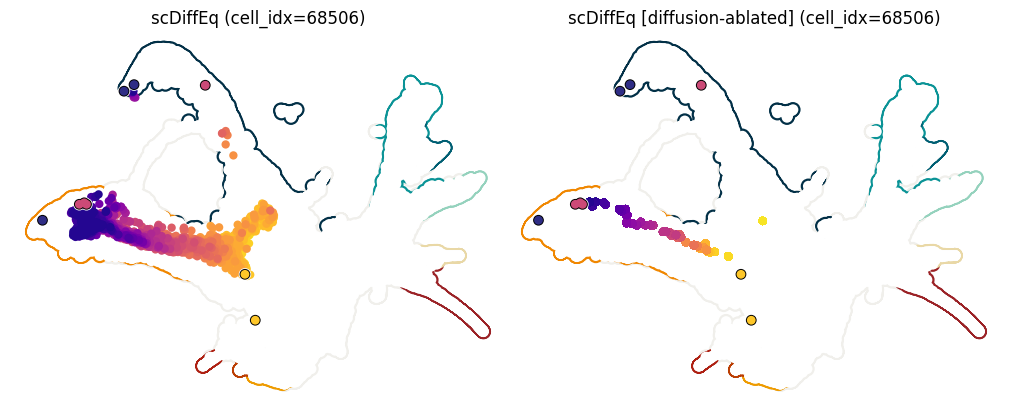

In [52]:
simulate(adata, model_ctrl, model_ablt, idx=idx)